Deal with unlabeled bbox (remove car IDs)
Goal: associate measurements to unique objects
1. try stitching objects in mutl-camera road

In [25]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import data_association as da
importlib.reload(da)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA
from shapely.geometry import Polygon

In [ ]:
# read & rectify each camera df individually

data_path = pathlib.Path().absolute().joinpath('../June_5min')
tform_path = pathlib.Path().absolute().joinpath('../tform')

# df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv"):
            
            # ... reading & preprocessing ...
            file_path = data_path.joinpath(file)
            df = utils.preprocess(file_path, tform_path, skip_row = 0)
            df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)
        
            # ... rectifying ...
            df = opt.rectify(df)
            
            # ... post processing ...
            df = utils.post_process(df)
            
            # ... saving ...
            new_name = 'rectified_' + file
            df.to_csv(data_path.joinpath('rectified/',new_name), index=False)
    break

Reading data...
Total # cars before preprocessing: 1810
Transform from image to road for p1c1...
Interpret missing timestamps...
No timestamps values
Constrain x,y range by camera FOV
0 130 -5 45
Filtering out tailing place holders...
Get the longest continuous frame chuck...
Get x direction...
Naive filter...
after direction=0 filter:  1115


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:67: RuntimeWarning: invalid value encountered in greater
  outliers =	np.logical_or(abs(w1 - m) > 2 * s,abs(w2 - m) > 2 * s)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:77: RuntimeWarning: invalid value encountered in greater
  outliers =	np.logical_or(abs(l1 - m) > 2 * s,abs(l2 - m) > 2 * s)


filter width length: 1115


100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [02:27<00:00,  7.55it/s]


cap width at 2.59m...
standardize format for plotter...


In [26]:
# read and preprocess data (one csv file)

data_path = pathlib.Path().absolute().joinpath('../June_5min')
tform_path = pathlib.Path().absolute().joinpath('../tform')
file_path = data_path.joinpath('p1c1_1_track_outputs_3D.csv')

df = utils.preprocess(file_path, tform_path, skip_row = 0)

Reading data...
Total # cars before preprocessing: 1810
Transform from image to road for p1c1...
Interpret missing timestamps...
No timestamps values
Constrain x,y range by camera FOV
0 130 -5 45
Filtering out tailing place holders...
Get the longest continuous frame chuck...
Get x direction...
Naive filter...
after direction=0 filter:  1115


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:67: RuntimeWarning: invalid value encountered in greater
  outliers =	np.logical_or(abs(w1 - m) > 2 * s,abs(w2 - m) > 2 * s)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:77: RuntimeWarning: invalid value encountered in greater
  outliers =	np.logical_or(abs(l1 - m) > 2 * s,abs(l2 - m) > 2 * s)


filter width length: 1115


In [28]:
groups = df.groupby('ID')
length = []
for carid, group in groups:
    print(carid, len(group))
    length.append(len(group))

111 19
1111 23
4111 31
6111 107
7111 47
9111 27
12111 55
13111 71
15111 59
20111 43
23111 107
25111 131
26111 79
27111 123
36111 123
39111 107
40111 87
51111 195
52111 115
55111 179
62111 443
64111 75
69111 99
74111 51
79111 87
80111 123
82111 107
89111 119
93111 43
95111 71
104111 115
105111 103
116111 111
137111 51
157111 115
162111 135
163111 31
166111 87
170111 119
176111 83
190111 151
191111 71
193111 71
194111 111
201111 151
204111 107
208111 35
211111 147
212111 71
213111 115
217111 143
218111 55
222111 123
223111 111
224111 95
226111 111
231111 139
242111 143
246111 71
247111 59
251111 127
252111 55
254111 115
263111 147
265111 163
272111 115
275111 315
280111 127
281111 119
292111 135
295111 115
301111 219
302111 151
308111 91
314111 23
315111 111
319111 87
320111 91
322111 107
327111 43
337111 59
338111 71
343111 83
350111 319
363111 99
365111 147
372111 111
377111 155
378111 111
383111 35
394111 271
397111 43
407111 103
408111 95
409111 131
410111 59
411111 91
412111 91
4131

3429111 135
3431111 51
3436111 127
3442111 99
3455111 95
3457111 115
3468111 95
3471111 111
3476111 83
3477111 99
3481111 59
3482111 51
3486111 91
3487111 103
3490111 63
3494111 103
3496111 123
3497111 127
3499111 71
3502111 91
3503111 135
3504111 111
3505111 27
3508111 11
3511111 107
3513111 103
3515111 119
3523111 67
3528111 95
3532111 115
3533111 95
3534111 99
3537111 123
3539111 111
3555111 95
3572111 87
3579111 167
3582111 99
3584111 227
3585111 127
3590111 143
3591111 99
3592111 99
3600111 115
3601111 107
3609111 111
3611111 79
3613111 111
3614111 83
3640111 103
3641111 99
3642111 135
3643111 115
3646111 75
3655111 155
3656111 103
3661111 87
3662111 51
3677111 15
3683111 59
3685111 139
3687111 91
3691111 139
3692111 119
3694111 55
3695111 167
3698111 147
3699111 123
3728111 143
3743111 119
3748111 119
3770111 127
3784111 115
3788111 111
3795111 15
3801111 115
3804111 119
3807111 19
3812111 111
3813111 35
3818111 31
3820111 95
3821111 131
3822111 83
3824111 67
3825111 123
3828111 

In [20]:
car = df[df['ID']==2076111]

No handles with labels found to put in legend.


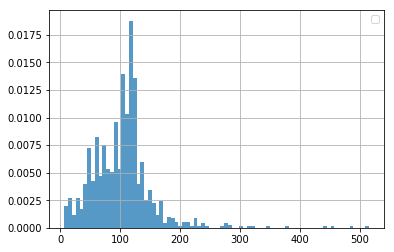

In [29]:
n, bins, patches = plt.hist(length, bins = 80, density=True, alpha=0.75)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
notnan = ~np.isnan(np.sum(np.array(car[['bbr_x']]),axis=1))
np.where(notnan)[0][-1]

184

In [21]:
car = car.iloc[20:185]

In [22]:
car

,Frame #,Timestamp,ID,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,...,bbl_y,direction,camera,acceleration,speed,x,y,theta,width,length
274438,3955,131.833333,2076111,pickup,431.633911,260.753235,472.216797,305.665710,0.543875,0.940991,...,3.342966,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274439,3956,131.866667,2076111,pickup,432.177795,261.694214,472.691986,306.599884,0.543875,0.940991,...,NaN,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274440,3957,131.900000,2076111,pickup,432.721680,262.635193,473.167175,307.534058,0.543875,0.940991,...,NaN,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274441,3958,131.933333,2076111,pickup,433.265564,263.576172,473.642365,308.468231,0.543875,0.940991,...,NaN,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274442,3959,131.966667,2076111,pickup,433.809448,264.517151,474.117554,309.402405,0.543875,0.940991,...,3.387428,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274598,4115,137.166667,2076111,pickup,567.353271,831.824646,677.746582,938.926331,1.592770,6.394951,...,3.331398,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274599,4116,137.200000,2076111,pickup,568.946045,838.219604,680.184875,945.239868,1.592770,6.394951,...,NaN,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274600,4117,137.233333,2076111,pickup,570.538818,844.614563,682.623169,951.553406,1.592770,6.394951,...,NaN,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274601,4118,137.266667,2076111,pickup,572.131592,851.009521,685.061462,957.866943,1.592770,6.394951,...,NaN,1.0,p1c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


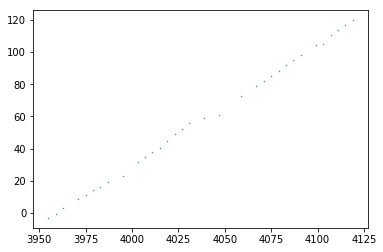

In [10]:
plt.scatter(car['Frame #'].values, car['bbr_x'].values, s= 0.2)

In [32]:
# stitching based on prediction and overlaps

import utils
importlib.reload(utils)

df = utils.preprocess_data_association(df)


Before DA:  225 cars
Frame :    0
Frame :  100
Frame :  200
Frame :  300
Frame :  400
Frame :  500
Frame :  600
Frame :  700
Frame :  800
Frame :  900
Frame : 1000
Frame : 1100
Frame : 1200
Frame : 1300
Frame : 1400
Frame : 1500
Frame : 1600
Frame : 1700


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:775: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ID'] = df['ID'].apply(lambda x: parent[x] if x in parent else x)


After stitching:  210 cars


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ID'] = df['ID'].apply(lambda x: parent[x] if x in parent else x)


After assocating overlaps:  201 cars
Get the longest continuous frame chunk...


100%|██████████████████████████████████████████████████████████████████████████████| 1798/1798 [00:26<00:00, 68.61it/s]


In [33]:
# try rectification
import utils_optimization as opt
importlib.reload(opt)
df = opt.rectify(df) # parallel, batch method

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [05:20<00:00,  1.59s/it]


In [34]:
df = utils.post_process(df)

cap width at 2.59m...
standardize format for plotter...


In [35]:
df.to_csv('../June_5min/rectified/rectified_p1c1_uncorrected_5min_1min.csv',index=False)

In [68]:
# make an animation based on LMCS
import os
import glob
import importlib
import animation_utils as an
importlib.reload(an)
image_folder = '../FramePic'

filelist = glob.glob(os.path.join(image_folder, "*"))
for f in filelist:
    os.remove(f)
    
if len(df['camera'].unique())==1:
    dim0 = get_camera_range(df['camera'][0])
else:
    dim0 = get_camera_range('all')
print(dim0)
dim = [d * 3.281 for d in dim0] # convert meter to feet
an.generate_frames(df, dim, skip_frame=1, image_folder=image_folder)

(0, 130, -5, 45)
Frame:  0 8994


In [69]:
# Fetch image files from the folder, and create an animation.
importlib.reload(an)
video_name = '../p1c1_uncorrected5min_DA.mp4'
an.write_video(image_folder, video_name, fps=30)

In [36]:
# visualize footprint on the camera video

import plot_rectified_objects
importlib.reload(plot_rectified_objects)

video = str(data_path.joinpath('raw_video/p1c1_1.mp4'))
label_file = str(data_path.joinpath('rectified/rectified_p1c1_uncorrected_5min_1min.csv')) 
# # label_file = str(data_path.joinpath('rectified/p1_all/rectified_p1c3.csv')) 
# # label_file = str(data_path.joinpath('rectified/uncorrected_individual/rectified_p1c3_uncorrected.csv'))
# # label_file = str(data_path.joinpath('rectified/uncorrected_all/rectified_p1c3.csv'))
plot_rectified_objects.plot_vehicle_csv(video,label_file, frame_rate = 10,show_2d = False,show_3d = True,show_LMCS = True,show_rectified = False, ds=True)


In [78]:
label_file

'C:\\Users\\wangy79\\Documents\\I24_trajectory\\I24-trajectory-generation\\..\\June_5min\\rectified\\rectified_p1c1_uncorrected_5min.csv'

In [ ]:
# read & rectify each camera df individually
import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4/')
tform_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021/i24-roadway-transforms-main/tform')

# df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv") and file.startswith('p1c6'):
            
            # ... reading ...
            file_name = data_path.joinpath(file)
            camera_id = utils.find_camera_name(file)
            print('reading ',camera_id,'...')
            
            # ... preprocessing ...
            df = utils.preprocess(file_name, tform_path)
            df = df.assign(camera=camera_id)
            df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)
        
            # ... rectifying ...
            df = opt.rectify(df)
            
            # ... post processing ...
            dfpp = utils.post_process(df)
            dfpp_img = utils.road_to_img(dfpp, tform_path)
            
            # ... saving ...
            new_name = 'rectified_' + camera_id +'.csv'
            dfpp_img.to_csv(new_name)
    break

In [ ]:
# plot 
import utils
importlib.reload(utils)
D = np.array(df[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D,15,5)

In [ ]:
fig, ax = plt.subplots()
# plt.xlim(xmin, xmax)
# plt.ylim(20, 42) # 0, 42
plt.xlabel('meter')
plt.ylabel('meter')
#plot design setup
plt.axhline(y = 21.25, color = 'black', linestyle = 'solid')
plt.axhline(y = 24, color = 'yellow', linestyle = '--')
plt.axhline(y = 18.5, color = 'yellow', linestyle = '--')
carColors=cm.rainbow(np.linspace(0,1,5))

# frameSnap = np.array(group[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
for carid, track in tracks.items():
    frameSnap = track
    c = carColors[carid%5]
    for j in range(len(frameSnap)):  # draw one vehicle onto the plot
    #     carID = int(frameSnap[j,0])  # Finding the unique carID for each vehicle in the frame
        coord = frameSnap[j,0:8]   # Finding the coordinates of the car
        if (np.isnan(coord).any()):
            print('nan')
            continue
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0])
        xs, ys = zip(*coord)
        plt.plot(xs,ys,c=c,label=carid if j==0 else '')
        #     plt.text(frameSnap[j,1], frameSnap[j,2], carID)
#     plt.legend()
